In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph

from common import h5dataset, traininer_gan, onnxexporter

class JassPlayDNN(nn.Module):
    def __init__(self, num_inputs=72, hidden_sizes=[512, 256, 128]):
        super(JassPlayDNN, self).__init__()
        layers = []
        layers.append(nn.Embedding(num_inputs, 13))
        in_dim = num_inputs * 13
        layers.append(nn.Flatten())
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h

        self.hidden = nn.Sequential(*layers)
        self.policy_head = nn.Linear(in_dim, 9)

    def forward(self, state_idx):
        x = self.hidden(state_idx)
        logits = self.policy_head(x)
        policy = F.log_softmax(logits, dim=1)
        return policy
    
class Discriminator(nn.Module):
    def __init__(self, num_inputs = 73, hidden_sizes=[512, 256]):
        super().__init__()
        layers = []
        layers.append(nn.Embedding(num_inputs, 13))
        in_dim = num_inputs * 13
        layers.append(nn.Flatten())
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, state_input, action):
        # Convert to float
        state_input = state_input
        action = action # Ensure shape (B, 1)

        x = torch.cat([state_input, action], dim=1)
        return self.net(x)


(process:13304): Pango-WARNING **: 10:17:23.836: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


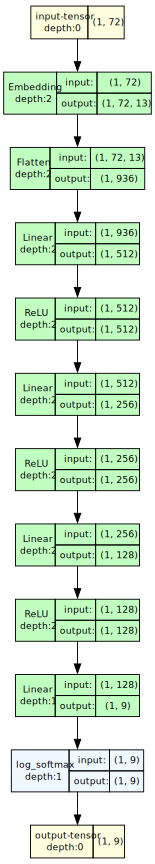


(process:26892): Pango-WARNING **: 10:17:24.132: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


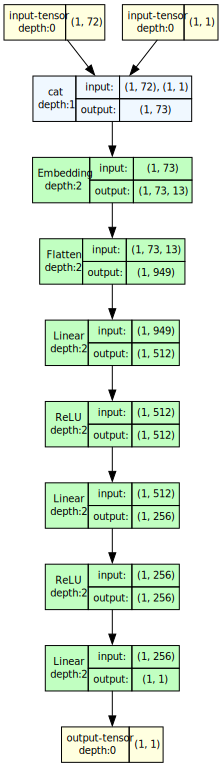

In [2]:
# Plot model graph
model = JassPlayDNN()
model_graph = draw_graph(model, torch.zeros(1, 72).long(), show_shapes=True)

descriminator = Discriminator()
discriminator_graph = draw_graph(descriminator, (torch.zeros(1, 72).long(), torch.zeros(1, 1).long()), show_shapes=True)

display(model_graph.visual_graph)
display(discriminator_graph.visual_graph)

In [3]:

DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
MODLE_PATH = './models'
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model = JassPlayDNN()
model.load_state_dict(torch.load(f"{MODLE_PATH}/JassPlayDNN_512_256_128.pth"))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
discriminator = Discriminator().to(device)
disc_optimizer = optim.Adam(descriminator.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()

# set up trainer
traininer = traininer_gan.TrainerGan(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=torch.nn.BCEWithLogitsLoss(),
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [4]:
# train the model
traininer.train(NUM_EPOCHS, model, descriminator, optimizer, disc_optimizer, 'JassPlayGan')

Training Epoch 1:   0%|          | 0/69329 [00:00<?, ?it/s]

Validation Epoch 1: 100%|██████████| 17333/17333 [01:05<00:00, 263.44it/s]


Epoch 1/20 - Generator Train Loss: 0.6928, Discriminator Train Loss: 1.3775, Generator Val Loss: 0.7136, Discriminator Val Loss: 1.3715
Model saved at epoch 1 with generator loss 0.7136


Validation Epoch 2: 100%|██████████| 17333/17333 [00:58<00:00, 296.58it/s]


Epoch 2/20 - Generator Train Loss: 0.6912, Discriminator Train Loss: 1.3679, Generator Val Loss: 0.7131, Discriminator Val Loss: 1.3645
Model saved at epoch 2 with generator loss 0.7131


Validation Epoch 3: 100%|██████████| 17333/17333 [00:56<00:00, 304.29it/s]


Epoch 3/20 - Generator Train Loss: 0.6901, Discriminator Train Loss: 1.3621, Generator Val Loss: 0.7271, Discriminator Val Loss: 1.3606
Model saved at epoch 3 with generator loss 0.7271


Validation Epoch 4: 100%|██████████| 17333/17333 [00:57<00:00, 299.31it/s]


Epoch 4/20 - Generator Train Loss: 0.6892, Discriminator Train Loss: 1.3578, Generator Val Loss: 0.7398, Discriminator Val Loss: 1.3564
Model saved at epoch 4 with generator loss 0.7398


Validation Epoch 5: 100%|██████████| 17333/17333 [00:57<00:00, 300.28it/s]


Epoch 5/20 - Generator Train Loss: 0.6885, Discriminator Train Loss: 1.3543, Generator Val Loss: 0.7288, Discriminator Val Loss: 1.3531
Model saved at epoch 5 with generator loss 0.7288


Validation Epoch 6: 100%|██████████| 17333/17333 [00:57<00:00, 301.32it/s]


Epoch 6/20 - Generator Train Loss: 0.6879, Discriminator Train Loss: 1.3517, Generator Val Loss: 0.7298, Discriminator Val Loss: 1.3516
Model saved at epoch 6 with generator loss 0.7298


Validation Epoch 7: 100%|██████████| 17333/17333 [00:58<00:00, 296.17it/s]


Epoch 7/20 - Generator Train Loss: 0.6875, Discriminator Train Loss: 1.3497, Generator Val Loss: 0.7340, Discriminator Val Loss: 1.3501
Model saved at epoch 7 with generator loss 0.7340


Validation Epoch 8: 100%|██████████| 17333/17333 [00:59<00:00, 293.12it/s]


Epoch 8/20 - Generator Train Loss: 0.6872, Discriminator Train Loss: 1.3481, Generator Val Loss: 0.7414, Discriminator Val Loss: 1.3486
Model saved at epoch 8 with generator loss 0.7414


Validation Epoch 9: 100%|██████████| 17333/17333 [00:58<00:00, 298.22it/s]


Epoch 9/20 - Generator Train Loss: 0.6871, Discriminator Train Loss: 1.3469, Generator Val Loss: 0.7398, Discriminator Val Loss: 1.3482
Model saved at epoch 9 with generator loss 0.7398


Validation Epoch 10: 100%|██████████| 17333/17333 [00:57<00:00, 300.27it/s]


Epoch 10/20 - Generator Train Loss: 0.6869, Discriminator Train Loss: 1.3460, Generator Val Loss: 0.7401, Discriminator Val Loss: 1.3477
Model saved at epoch 10 with generator loss 0.7401


Validation Epoch 11: 100%|██████████| 17333/17333 [00:57<00:00, 301.13it/s]


Epoch 11/20 - Generator Train Loss: 0.6868, Discriminator Train Loss: 1.3452, Generator Val Loss: 0.7330, Discriminator Val Loss: 1.3477
Model saved at epoch 11 with generator loss 0.7330


Validation Epoch 12: 100%|██████████| 17333/17333 [00:55<00:00, 310.26it/s]


Epoch 12/20 - Generator Train Loss: 0.6867, Discriminator Train Loss: 1.3445, Generator Val Loss: 0.7339, Discriminator Val Loss: 1.3470
Model saved at epoch 12 with generator loss 0.7339


Validation Epoch 13: 100%|██████████| 17333/17333 [01:04<00:00, 267.32it/s]


Epoch 13/20 - Generator Train Loss: 0.6865, Discriminator Train Loss: 1.3439, Generator Val Loss: 0.7363, Discriminator Val Loss: 1.3461
Model saved at epoch 13 with generator loss 0.7363


Validation Epoch 14: 100%|██████████| 17333/17333 [01:04<00:00, 266.80it/s]


Epoch 14/20 - Generator Train Loss: 0.6865, Discriminator Train Loss: 1.3433, Generator Val Loss: 0.7333, Discriminator Val Loss: 1.3468
Model saved at epoch 14 with generator loss 0.7333


Validation Epoch 15: 100%|██████████| 17333/17333 [01:08<00:00, 252.03it/s]


Epoch 15/20 - Generator Train Loss: 0.6865, Discriminator Train Loss: 1.3429, Generator Val Loss: 0.7334, Discriminator Val Loss: 1.3456
Model saved at epoch 15 with generator loss 0.7334


Validation Epoch 16: 100%|██████████| 17333/17333 [00:59<00:00, 291.23it/s]


Epoch 16/20 - Generator Train Loss: 0.6864, Discriminator Train Loss: 1.3425, Generator Val Loss: 0.7439, Discriminator Val Loss: 1.3457
Model saved at epoch 16 with generator loss 0.7439


Validation Epoch 17: 100%|██████████| 17333/17333 [01:04<00:00, 267.44it/s]


Epoch 17/20 - Generator Train Loss: 0.6864, Discriminator Train Loss: 1.3421, Generator Val Loss: 0.7393, Discriminator Val Loss: 1.3456
Model saved at epoch 17 with generator loss 0.7393


Validation Epoch 18: 100%|██████████| 17333/17333 [01:05<00:00, 264.94it/s]


Epoch 18/20 - Generator Train Loss: 0.6863, Discriminator Train Loss: 1.3418, Generator Val Loss: 0.7398, Discriminator Val Loss: 1.3456
Model saved at epoch 18 with generator loss 0.7398


Validation Epoch 19: 100%|██████████| 17333/17333 [01:05<00:00, 265.34it/s]


Epoch 19/20 - Generator Train Loss: 0.6863, Discriminator Train Loss: 1.3415, Generator Val Loss: 0.7438, Discriminator Val Loss: 1.3457
Model saved at epoch 19 with generator loss 0.7438


Validation Epoch 20: 100%|██████████| 17333/17333 [01:05<00:00, 266.63it/s]

Epoch 20/20 - Generator Train Loss: 0.6863, Discriminator Train Loss: 1.3412, Generator Val Loss: 0.7447, Discriminator Val Loss: 1.3458
Model saved at epoch 20 with generator loss 0.7447


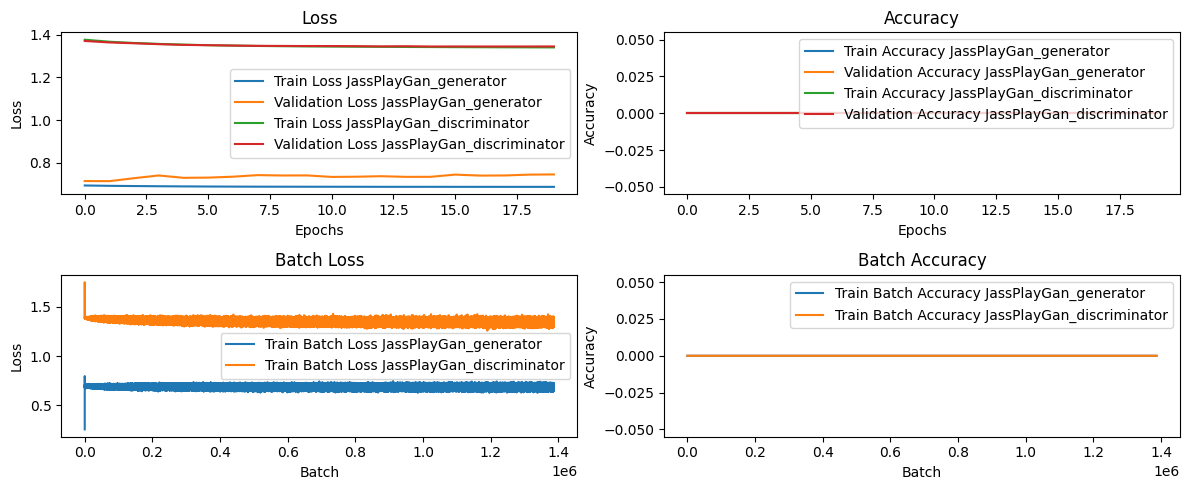

In [5]:
# create graphs
traininer.monitor.plot()

In [6]:
traininer.monitor.dump(MODLE_PATH + '/logs')

In [ ]:
# export the model to ONNX
ONNX_PATH = './onnx/jass_gan_dnn.onnx'
model = JassPlayDNN() # Reinitialize the model for export on CPU
onnxexporter.onnx_exporter(
    model=model,
    in_dim=72,
    model_path=MODLE_PATH,
    output_path=ONNX_PATH
)

Successfully loaded trained model state dictionary from ./models/jass_play_dnn.pth
Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./onnx/jass_play_dnn.onnx
